# Creating Synthetic Clouds in Python

This notebook implements a cloud-generation algorithm based on this [example in C](http://lodev.org/cgtutor/randomnoise.html)
The general idea is to create some white noise, and then progressivly upsampl smaller and smaller parts of the image and then stack the results on top of each other.

Here's the algorithm, in plain english:

> 1. generate an NxN white noise image and store it
2. cut out the upper-left quarter of the image
3. upsample the upper-left corner to the original image size, and store the result
4. repeat steps 2 and 3 until the corner image is 1x1
5. stack the original image, and all the stored upsampled images on top of each by adding the pixel values

I changed the order of the algorithm a little bit, but the result should be the same.

We can reproduce this in Python pretty easily.  I'm going to upgrade to bicubic interpolation because its 2017 and its a great time to be alive.

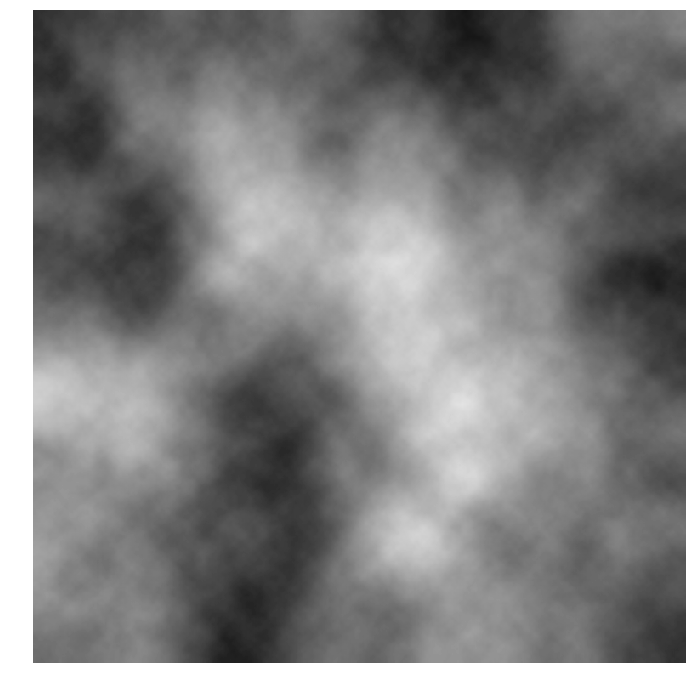

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.ndimage
%matplotlib inline

def make_turbulence(im_size):
    # Initialize
    base_pattern = np.random.uniform(0,255, (im_size, im_size))
    turbulence_pattern = np.zeros((im_size, im_size))

    # Create cloud pattern
    power_range = range(2, int(np.log2(im_size)))
    for i in power_range:
        subimg_size = 2**i
        quadrant = base_pattern[:subimg_size, :subimg_size]
        upsampled_pattern = scipy.misc.imresize(quadrant, (im_size, im_size), interp='bicubic')
        # intperp can be 'nearest', 'lanczos', 'bilinear', 'bicubic' or 'cubic'
        turbulence_pattern += upsampled_pattern / subimg_size

    # Normalize values
    turbulence_pattern /= sum([1 / 2**i for i in power_range])
    
    return turbulence_pattern
    

turbulence_pattern = make_turbulence(768)

# Plot the results
_, ax = plt.subplots(figsize=(12,12))
norm = matplotlib.colors.Normalize(vmin=0, vmax=255, clip=True)
ax.imshow(turbulence_pattern, cmap=plt.cm.gray, norm=norm)
ax.axis('off');


Now that we have a cloud pattern, let's add it to an image.  In order to do that, we'll use PIL, the Python Image Library.  

First, let's load a totally clear, non-cloudy image.

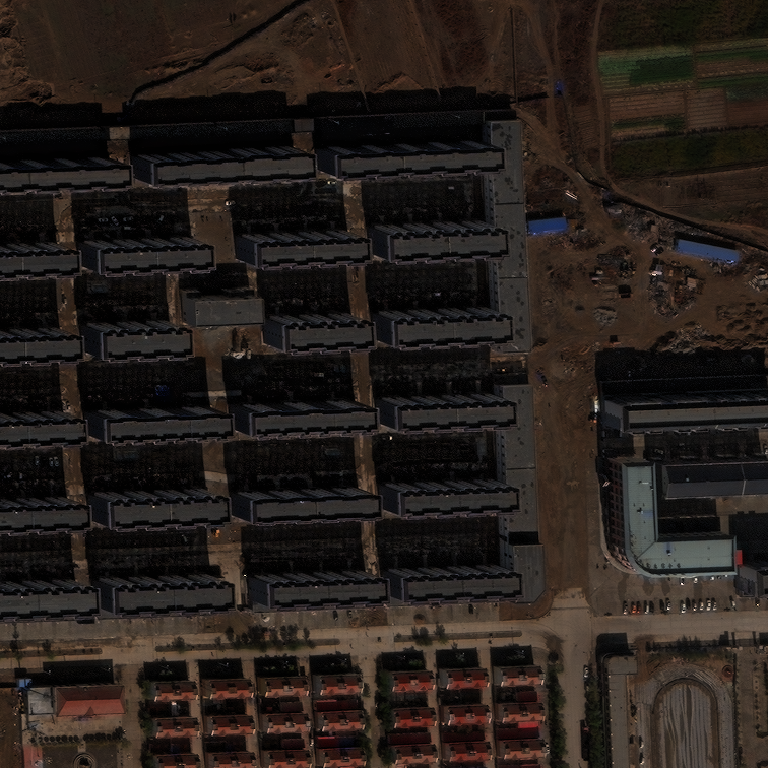

In [2]:
from PIL import Image

# Load the clear image
img = Image.open('61.png')

img

Then, we'll convert the cloud pattern into a PIL format, so it's ready to be merged with another image.  Finally, we can merge the images together.

RGB RGB
(768, 768) (768, 768)


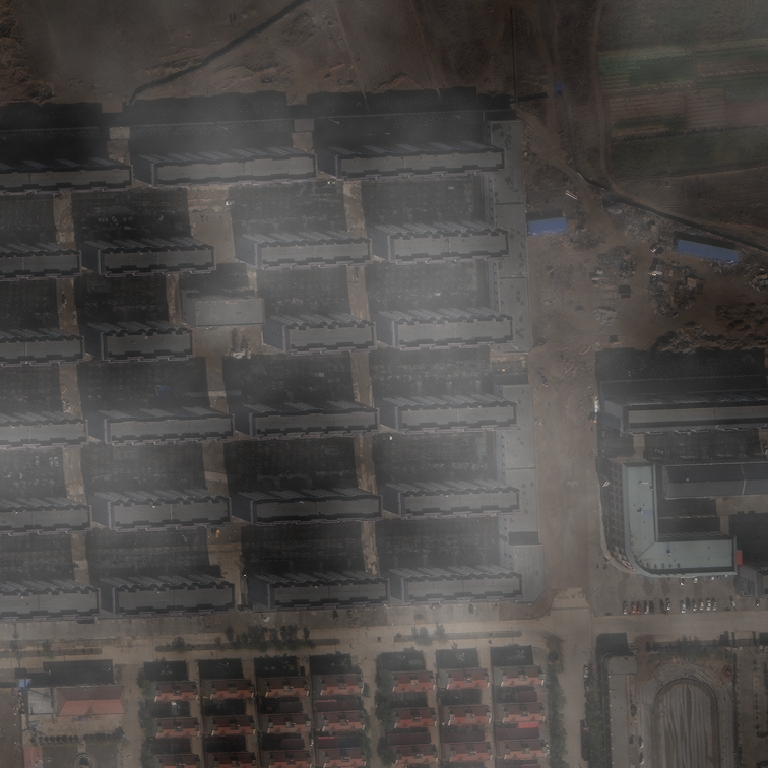

In [3]:
# Convert the turbulence pattern into a PIL RGB image
turb_img = Image.fromarray(np.dstack([turbulence_pattern.astype(np.uint8)]*3))

# Make sure that the images match each other
print(img.mode, turb_img.mode)
print(img.size, turb_img.size)

# Now try blending them
Image.blend(img, turb_img, 0.5)

We used the [`Image.blend`](http://pillow.readthedocs.io/en/3.4.x/reference/Image.html#PIL.Image.blend) function to combine the images.  The third parameter is the alpha value to use for blending.  If alpha is 0.0, we'll get the original image with no clouds.  If it's 1.0, we'll just get clouds with nothing else.  Let's try varying the alpha channel and see what it looks like.

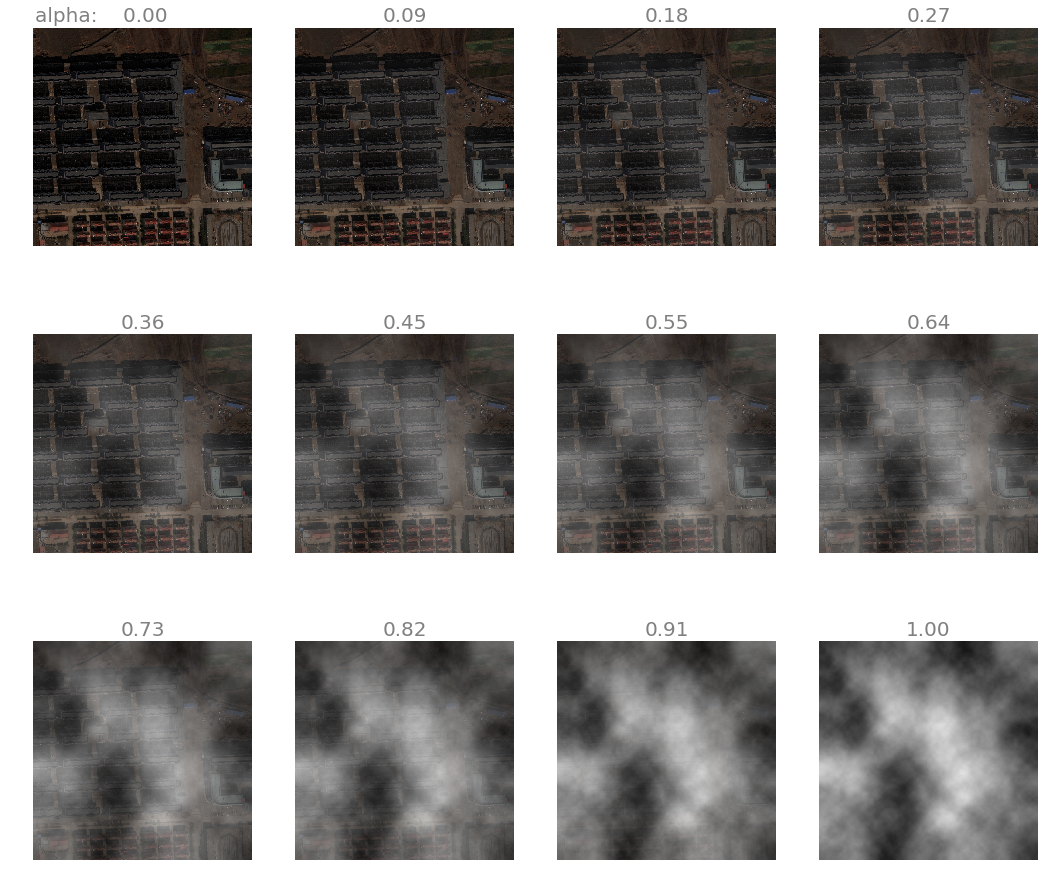

In [4]:
n_levels = 12
fig, axes = plt.subplots(3, n_levels//3, figsize=(18,16))
flag = True
for ax, alpha in zip(axes.flat, np.linspace(0,1,n_levels)):
    ax.imshow(Image.blend(img, turb_img, alpha))
    ax.axis('off')
    if flag:
        ax.set_title("alpha:    {:.2f}             ".format(alpha), fontsize=20, color='gray')
        flag = False
    else:
        ax.set_title("{:.2f}".format(alpha), fontsize=20, color='gray')

Now we can see a range of images with different alpha levels.  For augmentation, we'll want to avoid images that are so cloudy we can't make out the objects.  For this reason, we'll set an upper bound of 0.65 on the alpha parameter.  On the other hand, we don't want to waste our time creating augmented images that don't even look cloudy, so let's set a minimum alpha value of 0.2.

Now let's create an add_clouds function that we can use to augment images in the future.  To speed things up a little, we're dropping PIL and just using pure numpy.  This function assumes we're dealing with square images.  If you want it to work with non-square images, you'll have to modify the script to resize the clouds to match the image size.

Then let's add some clouds to [my favorite map projection](https://xkcd.com/977/), the [Peirce Quincuncial projection](https://en.wikipedia.org/wiki/Peirce_quincuncial_projection).

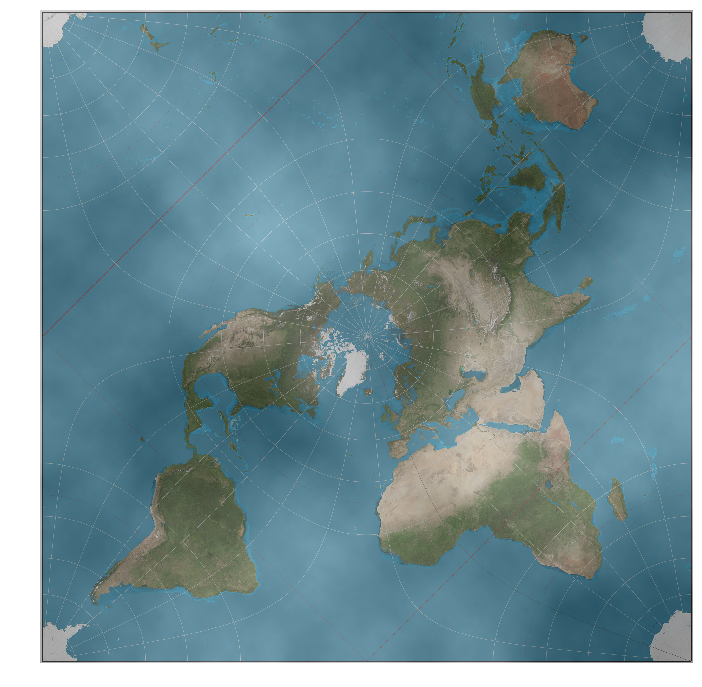

In [5]:
def add_clouds(image_np, alpha):
    turbulence_pattern = make_turbulence(image_np.shape[0])
    return (image_np*(1-alpha) + turbulence_pattern[:,:,None]*alpha).astype(np.uint8)

image_np = np.array(Image.open('/home/alan/Desktop/clouds/Peirce_quincuncial_projection_SW_20W.JPG'))
alpha = np.random.uniform(0.2, 0.65)
cloudy_image_np = add_clouds(image_np, alpha)

_, ax = plt.subplots(figsize=(12,12))
ax.imshow(cloudy_image_np)
ax.axis('off');